In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [2]:
video_path = "data/GoPro Video/GX010100_sample.MP4"

In [3]:
from torchvision.io import VideoReader

stream = "video"
video = VideoReader(video_path, stream)
video.get_metadata()

{'video': {'fps': [29.97002997002997], 'duration': [8.8601]},
 'audio': {'framerate': [48000.0], 'duration': [8.8600625]}}

In [4]:
import itertools
import pandas as pd

def example_read_video(video_object, start=0, end=None, read_video=True):
    if end is None:
        end = float("inf")
    if end < start:
        raise ValueError(
            "end time should be larger than start time, got "
            f"start time={start} and end time={end}"
        )
    
    df = pd.DataFrame(columns=["frame_number", "timestamp"])

    video_frames = torch.empty(0)
    video_pts = []
    if read_video:
        video_object.set_current_stream("video")
        frames = []
        for frame in itertools.takewhile(lambda x: x['pts'] <= end, video_object.seek(start)):
            frames.append(frame['data'])
            video_pts.append(frame['pts'])
        if len(frames) > 0:
            video_frames = torch.stack(frames, 0)

    # Add frame number and timestamp to dataframe
    df["frame_number"] = np.arange(len(video_pts))
    df["timestamp"] = video_pts

    return video_frames, video_pts, video_object.get_metadata(), df

In [5]:
# Total number of frames should be 327 for video and 523264 datapoints for audio
video_frames, frame_timestamps, meta, dataframe = example_read_video(video)
print(video_frames.size())

# Note: `frames` is a tensor of shape (T, C, H, W) where
    # T is the number of frames, C is the number of channels (3 for RGB), and H and W are the height and width of the video frames.

/Users/junwonchoi/.local/share/virtualenvs/parked_cars_road_classification-ovyX0Fkz/lib/python3.10/site-packages/torchvision/io/video_reader.py:245: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


torch.Size([266, 3, 1080, 1920])


In [6]:
# Explore obtained video information
print(video_frames.shape)

torch.Size([266, 3, 1080, 1920])


In [7]:
dataframe.head()

,frame_number,timestamp
0,0,0.000000
1,1,0.033367
2,2,0.066733
3,3,0.100100
4,4,0.133467


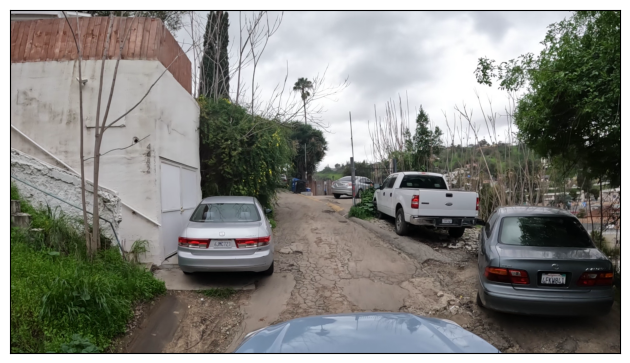

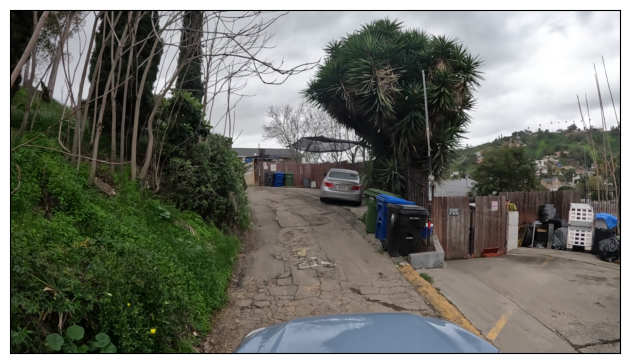

In [8]:
# Plot first frame
plot([video_frames[0]])

# Plot last frame
plot([video_frames[265]])

In [9]:
type(video_frames)

torch.Tensor

In [10]:
from torchvision.models import detection

# Load the pre-trained car detection model
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/Users/junwonchoi/.local/share/virtualenvs/parked_cars_road_classification-ovyX0Fkz/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/junwonchoi/.local/share/virtualenvs/parked_cars_road_classification-ovyX0Fkz/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
def detect_cars(frames):
    with torch.no_grad():
        input_tensor = frames.float() / 255.0  # Normalize the tensor frames if necessary
        input_batch = input_tensor.unsqueeze(0)
        output = model(input_batch)
        boxes = output[0]["boxes"].numpy()
        scores = output[0]["scores"].numpy()

        # Filter boxes with a confidence score above 0.5
        # boxes = boxes[scores >= 0.6]
        valid_indices = scores >= 0.90
        boxes = boxes[valid_indices]
        scores = scores[valid_indices]

    return boxes, scores

In [12]:
# Test detection on first frame
boxes1, scores1 = detect_cars(video_frames[0])

print(boxes1)
print(scores1)

[[1458.8438   620.089   1905.3234   975.19147]
 [ 528.92163  591.20013  831.77     835.69275]
 [1010.8834   524.3334  1147.7579   593.8575 ]
 [ 673.5044   944.49695 1566.5095  1072.0059 ]
 [1149.7719   503.92868 1481.9102   726.33997]]
[0.99923337 0.9988869  0.9943382  0.98511964 0.9421905 ]
